In [ ]:
import cv2
import numpy as np
from glob import glob
import networkx as nx
import matplotlib.pyplot as plt
import os

# === 參數設定 ===
image_dir = "data/scene"
min_inliers = 80
min_overlap = 0.01

# === 讀取圖片並抽 SIFT 特徵 ===
image_paths = sorted(glob(f"{image_dir}/*.png"))
sift = cv2.SIFT_create()

keypoints, descriptors = [], []
for p in image_paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)




In [6]:
import pandas as pd

# === 建立比對關係圖 ===
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
G = nx.Graph()
relations = []   # 存比對關係

for i in range(len(image_paths)):
    G.add_node(i, filename=os.path.basename(image_paths[i]))

for i in range(len(image_paths)):
    for j in range(i+1, len(image_paths)):
        if descriptors[i] is None or descriptors[j] is None:
            continue

        matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
        good = [m for m, n in matches if m.distance < 0.75 * n.distance]

        if len(good) > 0:
            pts1 = np.float32([keypoints[i][m.queryIdx].pt for m in good])
            pts2 = np.float32([keypoints[j][m.trainIdx].pt for m in good])

            F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 3.0)
            if F is not None and mask is not None:
                inliers = int(mask.sum())
                overlap = inliers / min(len(keypoints[i]), len(keypoints[j]))

                if inliers >= min_inliers and overlap >= min_overlap:
                    G.add_edge(i, j, weight=inliers)

                    # 存關係
                    relations.append({
                        "img1_index": i,
                        "img2_index": j,
                        "img1_name": os.path.basename(image_paths[i]),
                        "img2_name": os.path.basename(image_paths[j]),
                        "inliers": inliers,
                        "overlap": overlap
                    })

# === 輸出關係到 CSV ===
df = pd.DataFrame(relations)
df.to_csv("match_relations.csv", index=False)
print(f"➡ 已存 {len(df)} 條關係到 match_relations.csv")


➡ 已存 2408 條關係到 match_relations.csv


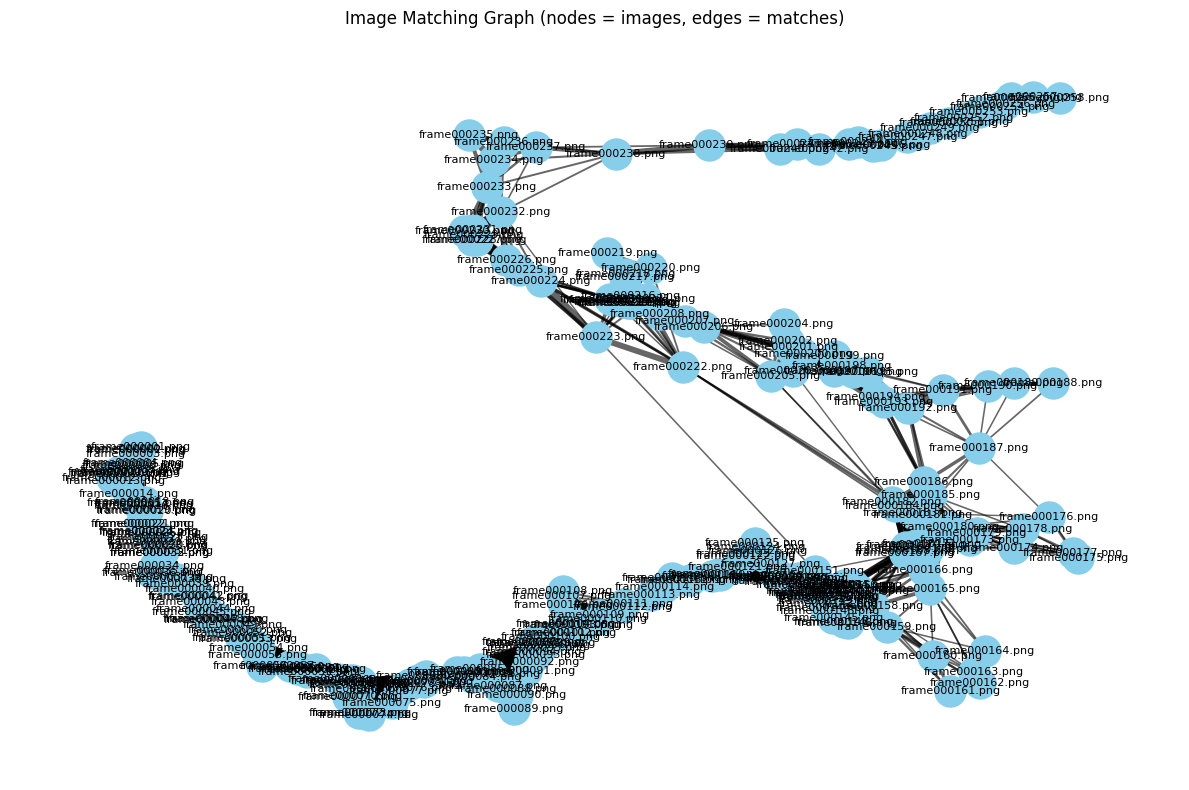

In [7]:
import matplotlib.pyplot as plt

# === 畫關係圖 ===
plt.figure(figsize=(12, 8))

# spring_layout：用邊的 weight (inliers) 來決定節點相對位置
pos = nx.spring_layout(G, weight="weight", seed=42)

# 畫節點
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")

# 畫邊（粗細依 inliers 數）
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, _ in edges],
    width=[d["weight"] / 50 for _, _, d in edges],  # 除以 50 調整粗細
    alpha=0.6
)

# 節點標籤（圖片名稱）
labels = {n: G.nodes[n]["filename"] for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Image Matching Graph (nodes = images, edges = matches)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [19]:
import os
import cv2
import networkx as nx

# === 1. 找出 degree >= 5 的節點 ===
candidates = [n for n, deg in G.degree() if deg >= 8]

# === 2. 過濾掉彼此相鄰的節點 ===
selected = []
for n in candidates:
    # 如果已選的節點裡沒有跟它相鄰的，就保留
    if not any(G.has_edge(n, s) for s in selected):
        selected.append(n)

print("最後挑選的節點數:", len(selected))

# === 3. 建立輸出資料夾 ===
output_dir = "filtered_images"
os.makedirs(output_dir, exist_ok=True)

# === 4. 轉存 PNG -> JPG ===
for n in selected:
    img_path = image_paths[n]
    filename = os.path.splitext(os.path.basename(img_path))[0] + ".jpg"
    out_path = os.path.join(output_dir, filename)

    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is not None:
        cv2.imwrite(out_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
        print(f"Saved: {out_path}")
    else:
        print(f"讀取失敗: {img_path}")


最後挑選的節點數: 31
Saved: filtered_images/frame000000.jpg
Saved: filtered_images/frame000014.jpg
Saved: filtered_images/frame000025.jpg
Saved: filtered_images/frame000035.jpg
Saved: filtered_images/frame000044.jpg
Saved: filtered_images/frame000055.jpg
Saved: filtered_images/frame000063.jpg
Saved: filtered_images/frame000072.jpg
Saved: filtered_images/frame000082.jpg
Saved: filtered_images/frame000089.jpg
Saved: filtered_images/frame000099.jpg
Saved: filtered_images/frame000107.jpg
Saved: filtered_images/frame000114.jpg
Saved: filtered_images/frame000122.jpg
Saved: filtered_images/frame000134.jpg
Saved: filtered_images/frame000145.jpg
Saved: filtered_images/frame000160.jpg
Saved: filtered_images/frame000166.jpg
Saved: filtered_images/frame000173.jpg
Saved: filtered_images/frame000176.jpg
Saved: filtered_images/frame000186.jpg
Saved: filtered_images/frame000191.jpg
Saved: filtered_images/frame000196.jpg
Saved: filtered_images/frame000202.jpg
Saved: filtered_images/frame000207.jpg
Saved: filte

In [9]:
# # 移除太弱的邊（例如 inliers < 100 的）
# H = G.copy()
# H.remove_edges_from([(u,v) for u,v,d in H.edges(data=True) if d["weight"] < 100])

# components = list(nx.connected_components(H))
# for idx, comp in enumerate(components):
#     print(f"群組 {idx}: {len(comp)} 張圖")
